## Silkworm Rearing Segmentation Notebook
---
Classical CV – per‑class RGB‑purity thresholds + 5‑panel view

In [16]:
# Standard library
import os
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Configuration Parameters

# Directory containing input images and how many to process
IMAGE_DIR = "data/images"
NUM_SAMPLES = 10

# Color space conversion
GAMMA = 2.2  # sRGB ↔ linear RGB exponent

# Preprocessing settings
FOURIER_HIGH_PASS_RADIUS = 30           # radius (px) to cut low frequencies
CLAHE_CLIP = 2.0                        # CLAHE contrast limit
CLAHE_GRID = (8, 8)                     # CLAHE grid size

# (Visual-only) boost factor for green tones during display
GREEN_BOOST = 2.5

# Per-class luminance & purity thresholds (linear RGB)
# Worms are nearly neutral-colored and fairly bright
WORM_COLOR_RATIO_MAX = 1.2  # max(R,G,B)/min(R,G,B) ≤ this → “white-ish”
WORM_LUMINANCE_MIN  = 0.25  # linear-luminance threshold

# Leaves are green-dominated but can be quite dark
LEAF_GREEN_RATIO    = 0.8   # G ≥ max(R,B)×this
LEAF_LUMINANCE_MIN  = 0.05
LEAF_LUMINANCE_MAX  = 0.70

# Additional color-space cues
# Worm (HSV) thresholds –> alternate bright/low-sat detection
WORM_HSV_VALUE_MIN   = 195
WORM_HSV_SAT_MAX     = 60

# Leaf (CIELAB a*/L*) thresholds –> catch olive greens
LEAF_LAB_A_MAX       = -1
LEAF_LAB_L_MIN       = 20
LEAF_LAB_L_MAX       = 100

# Post-processing
# Minimum size for connected components (pixels)
MIN_COMPONENT_AREA = 300


In [18]:
# Pre-processing utilities

# Pre-compute inverse gamma for conversions
inverse_gamma = 1.0 / GAMMA

def sRGB_to_linear(image_srgb):
    """
    Convert an 8-bit sRGB image to float linear RGB in [0,1].
    """
    srgb_norm = image_srgb.astype(np.float32) / 255.0
    return np.power(srgb_norm, GAMMA)

def linear_to_sRGB(image_linear):
    """
    Convert float linear RGB in [0,1] back to 8-bit sRGB.
    """
    clipped = np.clip(image_linear, 0.0, 1.0)
    srgb_norm = np.power(clipped, inverse_gamma)
    return (srgb_norm * 255).astype(np.uint8)

def normalize_image_brightness(image_srgb, target_luma=0.35):
    """
    Scale every pixel so that the average luminance (Y) of the image 
    in linear RGB space equals `target_luma`.
    """
    linear = sRGB_to_linear(image_srgb)
    # Rec. 709 luma coefficients
    luma = 0.2126 * linear[..., 0] + 0.7152 * linear[..., 1] + 0.0722 * linear[..., 2]
    scale = target_luma / (luma.mean() + 1e-6)
    linear_scaled = np.clip(linear * scale, 0.0, 1.0)
    return linear_to_sRGB(linear_scaled)

def apply_gray_world_balance(image_srgb):
    """
    Simple Gray-World white balance: scale each channel so the 
    per-channel averages all equal the image’s overall mean.
    """
    img32 = image_srgb.astype(np.float32)
    avg_channels = img32.mean(axis=(0,1))
    overall_mean = avg_channels.mean()
    scales = overall_mean / (avg_channels + 1e-6)
    balanced = img32 * scales
    return np.clip(balanced, 0, 255).astype(np.uint8)

def high_pass_filter(image_gray, radius=FOURIER_HIGH_PASS_RADIUS):
    """
    Apply a Fourier high-pass filter by zeroing out a center square of frequencies.
    """
    h, w = image_gray.shape
    cy, cx = h // 2, w // 2

    # Compute DFT and shift the zero frequency to the center
    dft = cv2.dft(image_gray.astype(np.float32), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    # Create a mask that blocks the low frequencies in a square of side 2r
    mask = np.ones((h, w, 2), np.uint8)
    mask[cy-radius:cy+radius, cx-radius:cx+radius] = 0

    # Apply mask and inverse shift/DFT
    fshift = dft_shifted * mask
    f_ishift = np.fft.ifftshift(fshift)
    back = cv2.idft(f_ishift)

    # Compute magnitude and normalize to [0,255]
    magnitude = cv2.magnitude(back[..., 0], back[..., 1])
    return cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

def preprocess_image(image_rgb):
    """
    Full pipeline:
      1. Brightness normalization
      2. Gray-world white balance + CLAHE
      3. Fourier-based edge enhancement
      4. Optional green-hue boost for display
    """
    # 1: Normalize overall brightness in linear RGB space
    normed = normalize_image_brightness(image_rgb)

    # 2: Gray-world white balance, then CLAHE on L channel
    balanced = apply_gray_world_balance(normed)
    lab = cv2.cvtColor(balanced, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
    L_eq = clahe.apply(L)
    contrast = cv2.cvtColor(cv2.merge((L_eq, A, B)), cv2.COLOR_LAB2RGB)

    # 3: Edge boost via high-pass filter
    gray = cv2.cvtColor(contrast, cv2.COLOR_RGB2GRAY)
    hp_mask = high_pass_filter(gray)
    boosted = cv2.addWeighted(contrast, 1.0, cv2.cvtColor(hp_mask, cv2.COLOR_GRAY2RGB), 0.5, 0)

    # 4: (Optional) increase saturation of green hues for visualization
    hsv = cv2.cvtColor(boosted, cv2.COLOR_RGB2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)
    green_zone = (H >= 35) & (H <= 100) & (S >= 40)
    S[green_zone] *= GREEN_BOOST
    hsv[..., 1] = np.clip(S, 0, 255)

    return cv2.cvtColor(hsv.astype(np.uint8), cv2.COLOR_HSV2RGB)


In [19]:
# Segmentation utilities

def filter_small_components(binary_mask, min_size=MIN_COMPONENT_AREA):
    """
    Remove connected components smaller than `min_size` pixels.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(
        binary_mask.astype(np.uint8), connectivity=8
    )
    clean_mask = np.zeros_like(binary_mask, dtype=np.uint8)

    for label in range(1, num_labels):  # skip background label 0
        area = stats[label, cv2.CC_STAT_AREA]
        if area >= min_size:
            clean_mask[labels == label] = 1

    return clean_mask

def segment_worms_and_leaves(image_rgb):
    """
    Return two masks (worms, leaves) from an RGB image:
      - Worms: bright & neutral pixels (HSV + linear-RGB purity)
      - Leaves: green-dominant pixels (linear-RGB + CIELAB cues)
    """
    # Convert to linear RGB and compute luminance Y
    linear_rgb = sRGB_to_linear(image_rgb)
    R, G, B = linear_rgb[..., 0], linear_rgb[..., 1], linear_rgb[..., 2]
    luminance = 0.2126 * R + 0.7152 * G + 0.0722 * B

    # 1) Worm detection in HSV (bright, low-saturation)
    hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
    _, sat_hsv, val_hsv = cv2.split(hsv)
    worm_hsv_mask = (val_hsv >= WORM_HSV_VALUE_MIN) & (sat_hsv <= WORM_HSV_SAT_MAX)

    # 2) Worm detection in linear RGB (neutral color + luminance)
    rgb_ratio = np.max(linear_rgb, axis=2) / (np.min(linear_rgb, axis=2) + 1e-6)
    worm_rgb_mask = (rgb_ratio <= WORM_COLOR_RATIO_MAX) & (luminance >= WORM_LUMINANCE_MIN)

    worm_mask = worm_hsv_mask | worm_rgb_mask

    # 3) Leaf detection in linear RGB (green purity + luminance range)
    green_purity_mask = (G >= np.maximum(R, B) * LEAF_GREEN_RATIO) & \
                        (luminance >= LEAF_LUMINANCE_MIN) & \
                        (luminance <= LEAF_LUMINANCE_MAX)

    # 4) Leaf detection in CIELAB (a* negative + L* in range)
    lab = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2LAB).astype(np.int16)
    L_channel, a_channel, _ = cv2.split(lab)
    lab_mask = (a_channel <= LEAF_LAB_A_MAX) & \
               (L_channel >= LEAF_LAB_L_MIN) & \
               (L_channel <= LEAF_LAB_L_MAX)

    leaf_mask = green_purity_mask | lab_mask

    # 5) Resolve overlaps: if both labels claim a pixel, favor leaf
    worm_mask[leaf_mask] = False

    # 6) Clean up small artifacts with morphological ops and size filter
    kernel = np.ones((3, 3), np.uint8)
    worm_clean = cv2.morphologyEx(worm_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)
    worm_clean = cv2.morphologyEx(worm_clean,               cv2.MORPH_CLOSE, kernel, iterations=2)
    worm_clean = filter_small_components(worm_clean)

    leaf_clean = cv2.morphologyEx(leaf_mask.astype(np.uint8), cv2.MORPH_OPEN, kernel, iterations=2)
    leaf_clean = cv2.morphologyEx(leaf_clean,                cv2.MORPH_CLOSE, kernel, iterations=2)
    leaf_clean = filter_small_components(leaf_clean)

    return worm_clean, leaf_clean


In [20]:
# File loading
files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('jpg','jpeg','png'))]
assert files, "No images"; random.shuffle(files); files = files[:NUM_SAMPLES]

Processing IMG_3801.jpg


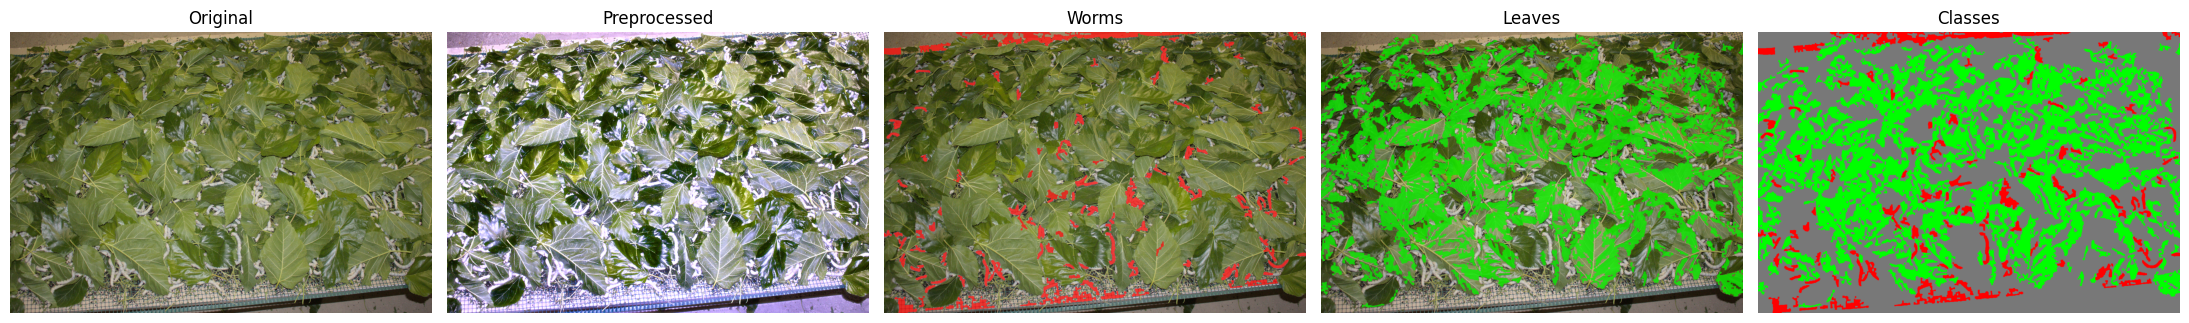

Processing IMG_2865.jpg


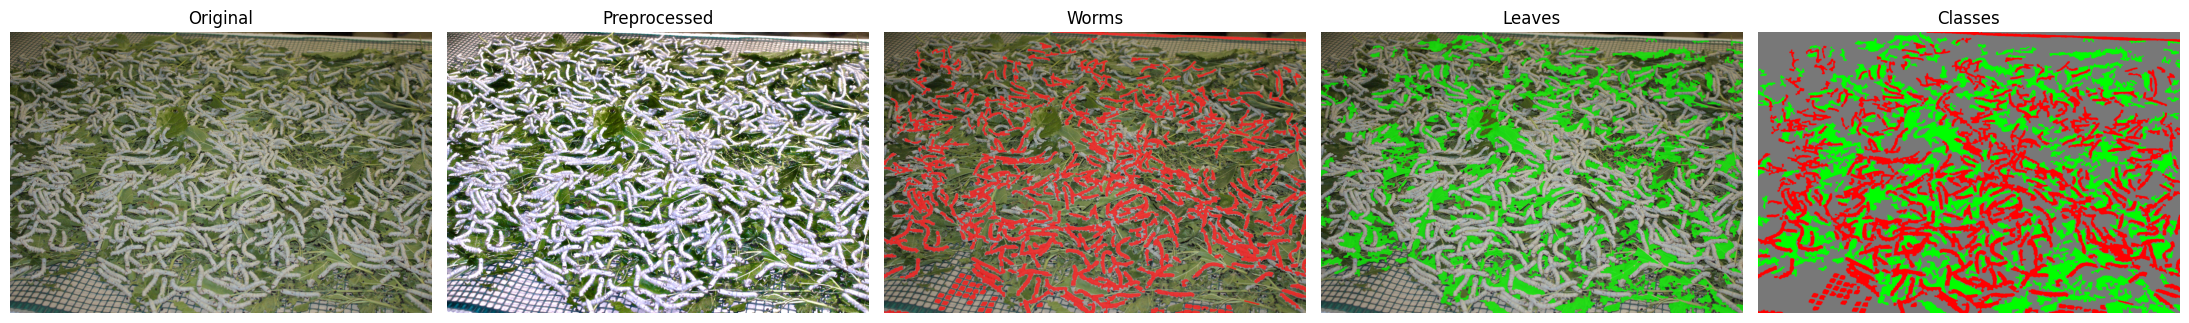

Processing IMG_3389.jpg


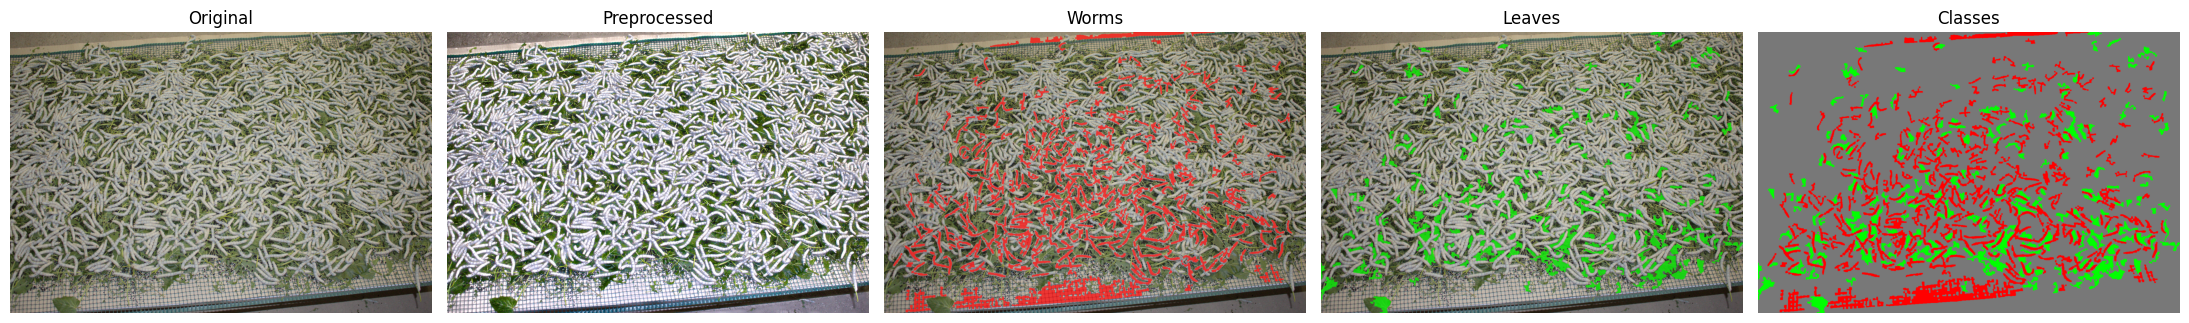

Done.


In [ ]:
# 6. Mask generation and visualization

def display_segmentation(original, preprocessed, worm_mask, leaf_mask):
    """
    Show a 5-panel figure:
        Original image
        Preprocessed image
        Worms overlay (red)
        Leaves overlay (green)
        Final class map (grey=background, red=worms, green=leaves)
    """
    # Create color overlays
    red_overlay   = original.copy()
    green_overlay = original.copy()
    red_overlay[worm_mask == 1]   = (
        red_overlay[worm_mask == 1] * 0.3 + np.array([255, 0, 0]) * 0.7
    ).astype(np.uint8)
    green_overlay[leaf_mask == 1] = (
        green_overlay[leaf_mask == 1] * 0.3 + np.array([0, 255, 0]) * 0.7
    ).astype(np.uint8)

    # Build a class map: grey background
    h, w, _ = original.shape
    class_map = np.full((h, w, 3), 120, dtype=np.uint8)
    class_map[leaf_mask == 1] = [0, 255, 0]
    class_map[worm_mask == 1] = [255, 0, 0]

    # Plot
    panels = [original, preprocessed, red_overlay, green_overlay, class_map]
    titles = ["Original", "Preprocessed", "Worms", "Leaves", "Classes"]

    fig, axes = plt.subplots(1, 5, figsize=(22, 4))
    for ax, img, title in zip(axes, panels, titles):
        ax.imshow(img)
        ax.set_title(title)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Process each image
for img_name in files:
    print("Processing", img_name)
    bgr_img = cv2.imread(os.path.join(IMAGE_DIR, img_name))
    if bgr_img is None:
        print(f"Skipped {img_name}: couldn't load")
        continue

    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    prepped = preprocess_image(rgb_img)
    worms, leaves = segment_worms_and_leaves(prepped)
    display_segmentation(rgb_img, prepped, worms, leaves)

print("Done.")
